In [0]:
import os
import shutil
from sklearn.ensemble import AdaBoostClassifier
from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification

import seaborn as sb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.ensemble import AdaBoostClassifier
from tqdm import tqdm
from sklearn.metrics import f1_score
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
pd.set_option('display.max_columns', 500)
from IPython.display import display
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
import sklearn.svm as svm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import files 
uploaded = files.upload() 

Saving SensorLog3001-12m.txt to SensorLog3001-12m.txt


In [0]:
import io 
data = np.loadtxt(io.BytesIO(uploaded['SensorLog3001-12m.txt']),dtype='str',delimiter=',')

In [0]:
dataset = pd.DataFrame({'House_Number': data[:, 0], 'Sensor_num': data[:, 1], 'Status': data[:, 2], 'Day': data[:, 3], 'Month': data[:, 4], 'Year': data[:, 5], 'Hour': data[:, 6], 'Min': data[:, 7], 'Counter': data[:, 8], 'Time_elapsed': data[:, 9]}
                      , columns=['House_Number', 'Sensor_num', 'Status','Day','Month', 'Year', 'Hour', 'Min', 'Counter','Time_elapsed' ])
bed_data = dataset.drop(['House_Number','Counter','Time_elapsed'], axis = 'columns')
bed_data[['Year','Day','Month','Hour','Min']] = bed_data[['Year','Day','Month','Hour','Min']].astype(int)
#slept = False
column_names = ["Month","Day","Sleeping duration: hr","Sleeping duration: min","Sleeping start: hr","Sleeping start: min","Sleeping end: hr","Sleeping end: min"]
DurationSlept = pd.DataFrame(columns = column_names)
j=0

for i,sensor in enumerate(bed_data.Sensor_num):
    if (sensor =='Sensor 7'):
      if (bed_data.loc[i].Status=="Chair Sensor Occupied"):
        bed_data['Status'][i] = 0
    if (sensor=='Sensor 5'):
      if (bed_data.loc[i].Status == "Pat's Bedroom Motion Activated"):
        bed_data['Status'][i] = 0
      else:
        bed_data['Status'][i] = 1
    elif(sensor=='Sensor 8'):
      if (bed_data.loc[i].Status == "ABS Bed Sensor Occupied" or bed_data.loc[i].Status == "ABS Bed Sensor was occupied"):
        bed_data['Status'][i] = 1
        slept = True
        day = bed_data.loc[i].Day
        hr = bed_data.loc[i].Hour
        minn = bed_data.loc[i].Min
#(bed_data.loc[i].Status == "ABS Bed Sensor Vacated" or bed_data.loc[i].Status == "ABS Bed Sensor Briefly Vacated")      
      else:
        bed_data['Status'][i] = 0
        if slept:
          hr2 =  bed_data.loc[i].Hour - hr
          if hr2<0:
            hr2+=24

          min2 = bed_data.loc[i].Min - minn
          if min2<0:
            min2+=60
          
          if hr2>0: 
            if (j==0):
              DurationSlept.loc[j]=([dataset.loc[i].Month, dataset.loc[i].Day,hr2,min2,hr,minn, dataset.loc[i].Hour, dataset.loc[i].Min])
            else:
              lastslept = DurationSlept.at[j-1,"Sleeping start: hr"] -hr
              if lastslept<0:
                lastslept+=24
              if (lastslept <2):
                DurationSlept.at[j-1,"Sleeping end: hr"] = bed_data.loc[i].Hour
                DurationSlept.at[j-1,"Sleeping end: min"] = bed_data.loc[i].Min
                DurationSlept.at[j-1,"Sleeping duration: hr"] += hr2
                DurationSlept.at[j-1,"Sleeping duration: min"] += min2
                j-=1
              else:
                DurationSlept.loc[j]=([dataset.loc[i].Month, dataset.loc[i].Day,hr2,min2,hr,minn, dataset.loc[i].Hour, dataset.loc[i].Min])
            j+=1
        slept =False
          #bed_data = bed_data.drop([i])
        
    else:
      bed_data = bed_data.drop([i])

bed_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: S

,Sensor_num,Status,Day,Month,Year,Hour,Min
10,Sensor 5,1,23,10,2017,10,27
22,Sensor 5,0,23,10,2017,10,50
25,Sensor 5,1,23,10,2017,10,52
36,Sensor 5,0,23,10,2017,11,28
37,Sensor 5,1,23,10,2017,11,31


(81, 8)


Text(0, 0.5, 'Sleeping hours')

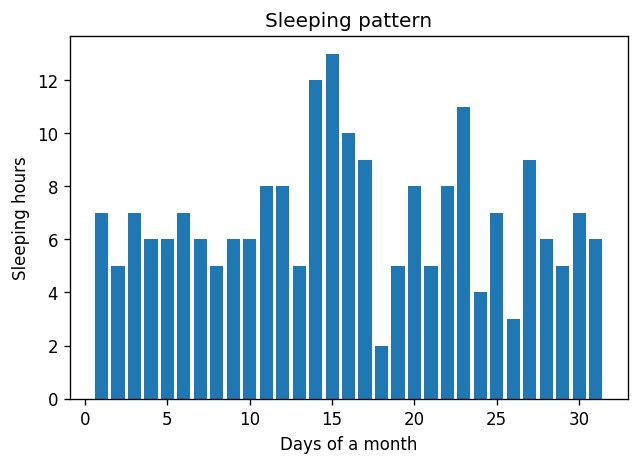

In [0]:
DurationSlept = DurationSlept.astype(int)
DurationSlept = DurationSlept.sort_values('Month')
OneMonthSleepingPattern = DurationSlept[(DurationSlept['Month']==3)]
print(OneMonthSleepingPattern.shape)
OneMonthSleepingPattern = OneMonthSleepingPattern.sort_values('Day')
fig, ax = plt.subplots(dpi=120)
ax.bar(OneMonthSleepingPattern['Day'],OneMonthSleepingPattern['Sleeping duration: hr'])
ax.set_title("Sleeping pattern")
ax.set_xlabel("Days of a month")
ax.set_ylabel("Sleeping hours")

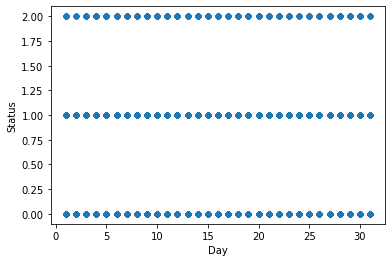

In [0]:
ax1 = bed_data.plot.scatter(x='Day',y='Status',alpha=0.5)

In [0]:
odd_days = [1,3,5]
even_days = [2,4,6]
bed_data = bed_data.reset_index(drop=True)
bed_data = bed_data.assign(Hour2 = lambda x: bed_data.Hour**2)
bed_data = bed_data.assign(Hour3 = lambda x: bed_data.Hour**3)
print(bed_data.head())
odd_data = bed_data[bed_data['Day'].isin(odd_days)]
even_data = bed_data[bed_data['Day'].isin(even_days)]

Xtrain = odd_data.drop(['Sensor_num','Status','Min'], axis = 'columns')
ytrain = odd_data['Status']
Xtest = even_data.drop(['Sensor_num','Status','Min'], axis = 'columns')
ytest = even_data['Status']
Xtrain = Xtrain.to_numpy()
ytrain = ytrain.to_numpy()
Xtest = Xtest.to_numpy()
ytest = ytest.to_numpy()

  Sensor_num Status  Day  Month  Year  Hour  Min  Hour2  Hour3
0   Sensor 5      1   23     10  2017    10   27    100   1000
1   Sensor 5      0   23     10  2017    10   50    100   1000
2   Sensor 5      1   23     10  2017    10   52    100   1000
3   Sensor 5      0   23     10  2017    11   28    121   1331
4   Sensor 5      1   23     10  2017    11   31    121   1331


In [0]:
def sensitivity_score(y,yhat):
    TP = np.logical_and(y==1,yhat==1).sum()
    FN = np.logical_and(y==1,yhat==0).sum()
    return TP/(TP+FN)
def specificity_score(y,yhat):
    TN = np.logical_and(y==0,yhat==0).sum()
    FP = np.logical_and(y==0,yhat==1).sum()
    return TN/(TN+FP)
def balanced_accuracy(y,yhat):
    fscore = f1_score(y, yhat)
    return fscore


100%|██████████| 50/50 [04:04<00:00,  4.89s/it]


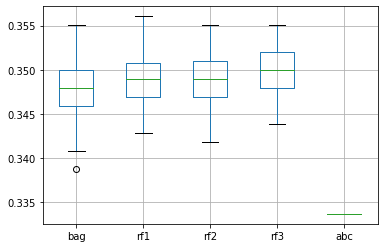

In [0]:
#svm grid search

ytrain = ytrain.astype(bool)
ytest = ytest.astype(bool)
number_of_simulations = 50

er = np.zeros(number_of_simulations)
er_rf1 = np.zeros(number_of_simulations)
er_rf2 = np.zeros(number_of_simulations)
er_rf3 = np.zeros(number_of_simulations)
er_abc = np.zeros(number_of_simulations)

err = np.zeros(number_of_simulations)
err_rf1 = np.zeros(number_of_simulations)
err_rf2 = np.zeros(number_of_simulations)
err_rf3 = np.zeros(number_of_simulations)
err_abc = np.zeros(number_of_simulations)
for i in tqdm(range(number_of_simulations)):

    # Instantiate Models
    # Use 500 trees in your random forests and bagged estimator.

    bag = BaggingClassifier( DecisionTreeClassifier(), n_estimators=500 )
    rf1 = RandomForestClassifier(n_estimators=500, max_features=1)
    rf2 = RandomForestClassifier(n_estimators=500, max_features=2)
    rf3 = RandomForestClassifier(n_estimators=500, max_features=3)
    abc = AdaBoostClassifier(n_estimators=500)
    
    
    bag.fit(Xtrain, ytrain)
    rf1.fit(Xtrain, ytrain)
    rf2.fit(Xtrain, ytrain)
    rf3.fit(Xtrain, ytrain)
    abc.fit(Xtrain, ytrain)

    yped = bag.predict(Xtrain)
    yped_rf1 = rf1.predict(Xtrain)
    yped_rf2 = rf2.predict(Xtrain)
    yped_rf3 = rf3.predict(Xtrain)
    yped_abc = abc.predict(Xtrain)

    ypred = bag.predict(Xtest)
    ypred_rf1 = rf1.predict(Xtest)
    ypred_rf2 = rf2.predict(Xtest)
    ypred_rf3 = rf3.predict(Xtest)
    ypred_abc = abc.predict(Xtest)
    
    er[i] =  accuracy_score(ytrain, yped)
    er_rf1[i] = accuracy_score(ytrain, yped_rf1)
    er_rf2[i] = 1- accuracy_score(ytrain, yped_rf2)
    er_rf3[i] = 1- accuracy_score(ytrain, yped_rf3)
    er_abc[i] = 1- accuracy_score(ytrain, yped_abc)
    # Record the testing error rate (that is 1 - accuracy).
    
    err[i] = 1 - accuracy_score(ytest, ypred)
    err_rf1[i] = 1- accuracy_score(ytest, ypred_rf1)
    err_rf2[i] = 1- accuracy_score(ytest, ypred_rf2)
    err_rf3[i] = 1- accuracy_score(ytest, ypred_rf3)
    err_abc[i] = 1- accuracy_score(ytest, ypred_abc)

#Plot the error rates as a box plot by model to complete the assignment.

estimators = {'bag': err, 'rf1': err_rf1,'rf2': err_rf2, 'rf3': err_rf3, 'abc': err_abc}

df = pd.DataFrame(estimators)

df

df.boxplot()


In [0]:
print(f"bag,train error {1-np.mean(er)} and test error  {1-np.mean(err)}")
print(f"rf1,train error {1-np.mean(er_rf1)} and test error  {1-np.mean(err_rf1)}  ")
print(f"rf2,train error {1-np.mean(er_rf2)} and test error  {1-np.mean(err_rf2)} ")
print(f"rf3,train error {1-np.mean(er_rf3)} and test error  {1-np.mean(err_rf3)} ")
print(f"abc,train error {1-np.mean(er_abc)} and test error  {1-np.mean(err_abc)} ")

bag,train error 0.6949152542372882 and test error  0.6522278738555443
rf1,train error 0.6949152542372882 and test error  0.6516581892166836  
rf2,train error 0.6949152542372882 and test error  0.6514547304170906 
rf3,train error 0.6949152542372882 and test error  0.6512512716174974 
abc,train error 0.6610169491525424 and test error  0.6663275686673449 


In [0]:
#going forward with adaboost classifier
abc = AdaBoostClassifier(n_estimators=500)


In [0]:
pip = Pipeline([
    ('standardize', StandardScaler()),
    ('abc' ,AdaBoostClassifier(n_estimators=500))
])
scoring={'spec':make_scorer(specificity_score),
        'sens':make_scorer(sensitivity_score)}
param_grid = {'abc__n_estimators':np.linspace(480,520,dtype=int)}
gscv = GridSearchCV(pip, param_grid=param_grid,scoring=scoring, cv = 5,n_jobs=4,refit="sens")
fitted = gscv.fit(Xtrain, ytrain)
res = pd.DataFrame(gscv.cv_results_)

In [0]:
yhat = fitted.predict(Xtest)
yhatt = fitted.predict(Xtrain)
res = pd.DataFrame(gscv.cv_results_)
err = 1 - accuracy_score(ytest, yhat)
errt = 1 - accuracy_score(ytrain, yhatt)
print("test err",err)
print("test accu",(1-err))
print("test err",errt)
print("test accu",(1-errt))
print(gscv.best_params_)

test err 0.3316378433367243
test accu 0.6683621566632757
test err 0.34004237288135597
test accu 0.659957627118644
{'abc__n_estimators': 480}


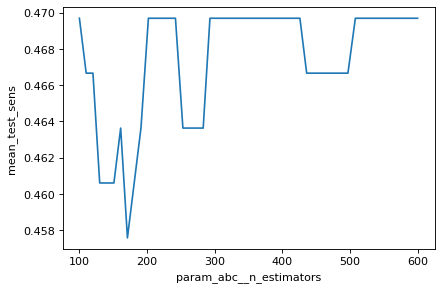

In [0]:
fig,ax =plt.subplots(dpi=80)
sb.lineplot(data=res,x='param_abc__n_estimators',y='mean_test_sens')

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    ax.axis('equal')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return ax


Confusion matrix, without normalization


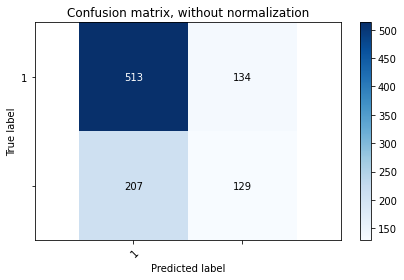

In [0]:
plot_confusion_matrix(ytest,yhat,np.array([0,1]))
